In [1]:
import os

In [2]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # For implicit ALS

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np

from implicit.als import AlternatingLeastSquares

from rectools.metrics import Precision, Recall, MAP, calc_metrics
from rectools.models import PopularModel, RandomModel, ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
import typing as tp
from tqdm import tqdm

from lightfm import LightFM

from implicit.bpr import BayesianPersonalizedRanking

from implicit.lmf import LogisticMatrixFactorization

In [5]:
%cd ../..

/home/kirill/PycharmProjects/pythonProject


In [6]:
DATA_PATH = Path("data/kion_train")

# LOAD DATA

In [7]:
%%time
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

CPU times: user 2.18 s, sys: 323 ms, total: 2.5 s
Wall time: 2.77 s


In [8]:
Columns.Datetime = 'last_watch_dt'

In [9]:
interactions.drop(interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True)

In [10]:
interactions[Columns.Datetime].str.len().value_counts()

10    5476251
Name: last_watch_dt, dtype: int64

In [11]:
interactions[Columns.Datetime].min(), interactions[Columns.Datetime].max()

('2021-03-13', '2021-08-22')

# Train/Test split

In [12]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [13]:
max_date = interactions[Columns.Datetime].max()

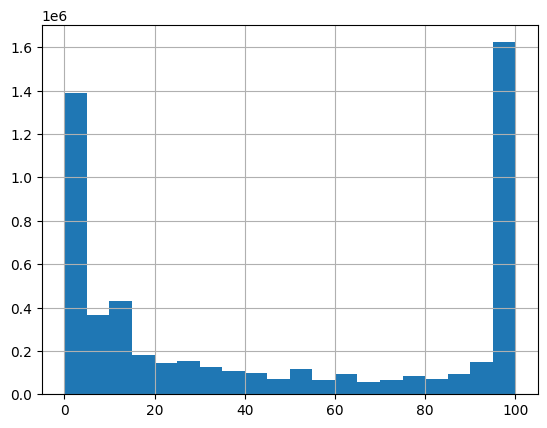

In [14]:
interactions['watched_pct'].hist(bins=20);

In [15]:
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 15, 3, 1)

In [16]:
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 6)
test: (490982, 6)


In [17]:
train.drop(train.query("total_dur < 300").index, inplace=True)

In [18]:
# отфильтруем холодных пользователей из теста
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [19]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

# MODELS

In [20]:
K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 16
N_FACTORS = (32, 64, 128, 160)
ITERATIONS = (15, 20)

In [21]:
dataset = Dataset.construct(
    interactions_df=train
)

In [22]:
models = {}

In [23]:
implicit_models = {
    'ALS': AlternatingLeastSquares,
}
for implicit_name, implicit_model in implicit_models.items():
    for n_factors in N_FACTORS:
        for iterations in ITERATIONS:
            models[f"{implicit_name}_{n_factors}_{iterations}"] = ImplicitALSWrapperModel(
                model=implicit_model(
                    factors=n_factors, 
                    random_state=RANDOM_STATE, 
                    num_threads=NUM_THREADS,
                    iterations=iterations,
                )
            )

In [24]:
metrics_name = {
    'Precision': Precision,
    'Recall': Recall,
    'MAP': MAP,
}

metrics = {}
for metric_name, metric in metrics_name.items():
    for k in range(1, 10+1):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [25]:
models

{'ALS_32_15': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f1a55302280>,
 'ALS_32_20': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f1a553023d0>,
 'ALS_64_15': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f1a55302460>,
 'ALS_64_20': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f1a553024f0>,
 'ALS_128_15': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f1a55302580>,
 'ALS_128_20': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f1a55302610>,
 'ALS_160_15': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f1a55302700>,
 'ALS_160_20': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f1a55302790>}

In [26]:
metrics

{'Precision@1': Precision(k=1),
 'Precision@2': Precision(k=2),
 'Precision@3': Precision(k=3),
 'Precision@4': Precision(k=4),
 'Precision@5': Precision(k=5),
 'Precision@6': Precision(k=6),
 'Precision@7': Precision(k=7),
 'Precision@8': Precision(k=8),
 'Precision@9': Precision(k=9),
 'Precision@10': Precision(k=10),
 'Recall@1': Recall(k=1),
 'Recall@2': Recall(k=2),
 'Recall@3': Recall(k=3),
 'Recall@4': Recall(k=4),
 'Recall@5': Recall(k=5),
 'Recall@6': Recall(k=6),
 'Recall@7': Recall(k=7),
 'Recall@8': Recall(k=8),
 'Recall@9': Recall(k=9),
 'Recall@10': Recall(k=10),
 'MAP@1': MAP(k=1, divide_by_k=False),
 'MAP@2': MAP(k=2, divide_by_k=False),
 'MAP@3': MAP(k=3, divide_by_k=False),
 'MAP@4': MAP(k=4, divide_by_k=False),
 'MAP@5': MAP(k=5, divide_by_k=False),
 'MAP@6': MAP(k=6, divide_by_k=False),
 'MAP@7': MAP(k=7, divide_by_k=False),
 'MAP@8': MAP(k=8, divide_by_k=False),
 'MAP@9': MAP(k=9, divide_by_k=False),
 'MAP@10': MAP(k=10, divide_by_k=False)}

In [27]:
results = []
for model_name, model in tqdm(models.items()):
    model_quality = {'model': model_name}

    model.fit(dataset)
    recos = model.recommend(
        users=test[Columns.User].unique(),
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True,
    )
    metric_values = calc_metrics(metrics, recos, test, train)
    model_quality.update(metric_values)
    results.append(model_quality)

100%|█████████████████████████████████████████████| 8/8 [08:56<00:00, 67.09s/it]


In [28]:
df_quality = pd.DataFrame(results).T

df_quality.columns = df_quality.iloc[0]

df_quality.drop('model', inplace=True)

In [29]:
df_quality.style.highlight_max(color='lightgreen', axis=1)

model,ALS_32_15,ALS_32_20,ALS_64_15,ALS_64_20,ALS_128_15,ALS_128_20,ALS_160_15,ALS_160_20
Precision@1,0.030697,0.031201,0.027377,0.027758,0.027422,0.028130,0.026997,0.026581
Recall@1,0.012572,0.012902,0.010839,0.011006,0.011003,0.011251,0.010785,0.010531
Precision@2,0.026470,0.026882,0.024863,0.025173,0.024416,0.024501,0.023695,0.023664
Recall@2,0.021383,0.021839,0.019486,0.019718,0.018992,0.019057,0.018579,0.018516
Precision@3,0.024704,0.025203,0.022952,0.023149,0.021910,0.022193,0.021314,0.021282
Recall@3,0.030061,0.030701,0.026478,0.026777,0.025264,0.025721,0.024757,0.024730
Precision@4,0.023430,0.023611,0.021460,0.021889,0.020228,0.020413,0.019535,0.019612
Recall@4,0.037795,0.038156,0.032590,0.033415,0.031031,0.031194,0.029907,0.029858
Precision@5,0.022199,0.022459,0.020259,0.020517,0.019057,0.019071,0.018167,0.018301
Recall@5,0.044473,0.045252,0.038442,0.038893,0.036307,0.036288,0.034399,0.034440


In [30]:
# The best model

K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 16
n_factors = (32)
iterations = (20)

dataset = Dataset.construct(
    interactions_df=train
)

model = ImplicitALSWrapperModel(
                model=AlternatingLeastSquares(
                    factors=n_factors, 
                    random_state=RANDOM_STATE, 
                    num_threads=NUM_THREADS,
                    iterations=iterations,
                ))

model.fit(dataset)
recos = model.recommend(
    users=test[Columns.User].unique(),
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

In [31]:
recos

,user_id,item_id,score,rank
0,203219,1819,0.110870,1
1,203219,12192,0.088950,2
2,203219,4740,0.076680,3
3,203219,5658,0.065292,4
4,203219,13018,0.055254,5
...,...,...,...,...
1129765,857162,14431,0.083407,6
1129766,857162,3076,0.082908,7
1129767,857162,1449,0.080706,8
1129768,857162,4880,0.078874,9


In [32]:
# Save recomendations

recos.to_csv('data/offline_reco_df/als', encoding='utf-8', index=False)

In [33]:
def create_dates(start, end, n=15):
    ndays = (end - start).days + 1
    range_ = np.random.randint(0, ndays, n)
    res_dates = pd.to_timedelta(range_, unit='D') + start
    return res_dates

# TEST USERS (AVATARS)

In [34]:
N_watched = 15

# User, who watch only movies for child
random_items = np.random.choice(
    np.array(items[items.for_kids == 1].item_id),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-1,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
total_dur = np.random.uniform(7000, 15000, size=N_watched).astype('int')
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_1 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

# User, who watch only one genre's movies ('militant')
random_items = np.random.choice(
    np.array(items[Columns.Item][items['genres'].apply(lambda x: 'боевики' in x)].unique()),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-2,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_2 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

# User, who watch only russian movies with age_rating > 18
random_items = np.random.choice(
    np.array(items[(items.countries == 'Россия') & (items.age_rating == 18.0)].item_id.unique()),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-3,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_3 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

In [35]:
# The best model

K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 16
n_factors = (32)
iterations = (20)

dataset = Dataset.construct(
    interactions_df=pd.concat([train, test_user_1, test_user_2, test_user_3])
)

model = ImplicitALSWrapperModel(
                model=AlternatingLeastSquares(
                    factors=n_factors, 
                    random_state=RANDOM_STATE, 
                    num_threads=NUM_THREADS,
                    iterations=iterations,
                ))

model.fit(dataset)
recos = model.recommend(
    users=np.append(test[Columns.User].unique(), np.array([-1, -2, -3])),
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

In [36]:
items[items.item_id.isin(recos[recos.user_id == -1].item_id)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
272,849,film,Дебошир,The Brawler,2018.0,"историческое, биография, криминал, драмы, спор...",США,NaN,18.0,NaN,Кен Кушнер,"Зэк Макгоун, Эми Смарт, Джо Пантольяно, Тэрин ...",Легендарный боксёр Чак Вепнер (на экране его и...,"2018, соединенные штаты, дебошир"
488,15399,series,Бывшие,NaN,2021.0,"драмы, мелодрамы",Россия,0.0,18.0,NaN,Иван Китаев,"Любовь Аксёнова, Денис Шведов, Полина Гагарина...",Яна выходит замуж за эксцентричного бизнесмена...,"Бывшие, 2021, Россия"
1508,16228,series,Содержанки,NaN,2021.0,триллеры,Россия,0.0,18.0,NaN,"Константин Богомолов, Дарья Жук, Юрий Мороз","Дарья Мороз, Софья Эрнст, Сергей Бурунов, Влад...","Тонкое исследование того, как и чем живёт стол...","Содержанки, 2021, Россия"
2212,13018,film,Король лев (2019),The Lion King,2019.0,"драмы, мультфильм, музыкальные",США,NaN,6.0,NaN,Джон Фавро,"Джеймс Эрл Джонс, Дональд Гловер, Чиветель Эдж...",История об отважном львенке по имени Симба. Зн...,"Африка, лев, принц, мюзикл, дядя, римейк, горе..."
5065,14461,film,Пара из будущего,NaN,2021.0,"мелодрамы, комедии",Россия,0.0,12.0,NaN,Алексей Нужный,"Сергей Бурунов, Мария Аронова, Денис Парамонов...","2040-й год. Супруги, которые долгие годы несча...","Пара, из, будущего, 2021, Россия"
7338,1554,film,Последний богатырь: Корень зла,NaN,2021.0,"семейное, фэнтези, приключения, комедии",Россия,0.0,6.0,NaN,Дмитрий Дьяченко,"Виктор Хориняк, Мила Сивацкая, Екатерина Вилко...",Тёмные силы повержены. В Белогорье наконец нас...,"Последний, богатырь, Корень, зла, 2021, Россия"
8275,2954,film,Миньоны,Minions,2015.0,"фантастика, мультфильм, приключения, комедии",США,NaN,6.0,NaN,"Кайл Балда, Пьер Коффан","Сандра Буллок, Джон Хэмм, Майкл Китон, Эллисон...",Миньоны живут на планете гораздо дольше нас. У...,"помощник, сцена после титров, сцена во время т..."
10506,3071,film,Родные,NaN,2021.0,"драмы, комедии",Россия,0.0,12.0,NaN,Илья Аксёнов,"Сергей Бурунов, Ирина Пегова, Сергей Шакуров, ...","Комедия с Сергеем Буруновым, Ириной Пеговой и ...","Родные, 2021, Россия"
10604,12192,series,Фемида видит,Femida vidit,2019.0,"драмы, детективы, комедии",Россия,NaN,16.0,NaN,"Никита Грамматиков, Ирина Бас","Анна Котова-Дерябина, Александр Давыдов, Алекс...",Лёгкий комедийный детектив от автора «Подслуша...,"фемида видит, фемида, феми, фем, фемид, фемида..."
12962,6382,series,Медиатор,NaN,2021.0,"драмы, триллеры, детективы",Россия,0.0,18.0,NaN,Артём Аксёненко,"Андрей Бурковский, Юлия Пересильд, Дарья Мороз...","Психологический триллер с Андреем Бурковским, ...","Медиатор, 2021, Россия"


In [37]:
items[items.item_id.isin(recos[recos.user_id == -2].item_id)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
1090,4702,film,Хищник,Predator,1987.0,"боевики, фантастика, триллеры, приключения","США, Мексика",NaN,16.0,NaN,Джон МакТирнан,"Арнольд Шварценеггер, Карл Уэзерс, Эльпидия Ка...",Американский вертолет был сбит партизанами в Ю...,"Центральная и Южная Америка, хищник, инопланет..."
1111,14242,film,Страховщик,Autómata,2014.0,"боевики, драмы, фантастика, триллеры","Испания, Болгария",NaN,16.0,NaN,Габе Ибаньес,"Антонио Бандерас, Дилан МакДермотт, Мелани Гри...",2044 год. После природной катастрофы население...,"искусственный интеллект, дождь, будущее, антиу..."
4123,12356,film,13 грехов,13 sins,2013.0,"ужасы, триллеры",США,NaN,16.0,NaN,Даниэль Штамм,"Марк Веббер, Рутина Уэсли, Девон Грайе, Прюитт...",Эллиот Бриндл — умный кроткий сотрудник службы...,"отель, детектив, заложник, шантаж, новый орлеа..."
6839,10464,film,Вирус страха,Before the fire,2020.0,"драмы, триллеры",США,NaN,16.0,NaN,Чарли Бюхлер,"Дженна Линг, Джексон Дэвис, Райан Виджилант, Ч...",Из-за начавшейся пандемии известная актриса вы...,"выживальщик, нелегальная милиция, 2020, соедин..."
7716,676,film,Человек-невидимка,The Invisible Man,2020.0,"фантастика, ужасы, триллеры, детективы","Австралия, США, Канада, Великобритания",NaN,18.0,NaN,Ли Уоннелл,"Элизабет Мосс, Оливер Джексон-Коэн, Харриет Да...",На первый взгляд жизнь Сесилии кажется безупре...,"сталкер, домашнее насилие, невидимка, 2010-е, ..."
8275,2954,film,Миньоны,Minions,2015.0,"фантастика, мультфильм, приключения, комедии",США,NaN,6.0,NaN,"Кайл Балда, Пьер Коффан","Сандра Буллок, Джон Хэмм, Майкл Китон, Эллисон...",Миньоны живут на планете гораздо дольше нас. У...,"помощник, сцена после титров, сцена во время т..."
9933,16361,film,Doom: Аннигиляция,Doom: Annihilation,2019.0,"боевики, ужасы, фантастика, триллеры",США,NaN,18.0,NaN,Тони Гиглио,"Эми Мэнсон, Доминик Мафэм, Люк Аллен-Гейл, Дже...",Отряд морпехов прилетает на марсианский спутни...,"планета Марс, ад, космос, демон, по мотивам ви..."
10014,5250,film,Золото джунглей,Oro,2017.0,"драмы, приключения",Испания,NaN,18.0,NaN,Агустин Диас Янес,"Рауль Аревало, Барбара Ленни, Оскар Хаэнада, Х...",1538 год. Король Испании и император священной...,"Эльдорадо, 2017, испания, золото, джунглей"
14315,13411,film,Вальгалла: Рагнарёк,Valhalla,2019.0,"фэнтези, триллеры, приключения","Дания, Норвегия, Швеция, Исландия",NaN,12.0,NaN,Фенар Ахмад,"Роланд Мюллер, Дульфи Аль-Джабури, Сесилия Лоф...","Близится Рагнарек, и великие боги Асгарда соби...","2019, дания, норвегия, швеция, исландия, вальг..."
14598,5287,film,Брешь,Anti-Life (Breach),2020.0,"боевики, ужасы, фантастика",Канада,NaN,18.0,NaN,Джон Суитц,"Коуди Кирсли, Брюс Уиллис, Рэйчел Николс, Тимо...",2242 год. Земля обречена. Среди 50 миллионов и...,"инопланетянин, меняющий форму, 2020, канада, б..."


In [38]:
items[items.item_id.isin(recos[recos.user_id == -3].item_id)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
488,15399,series,Бывшие,NaN,2021.0,"драмы, мелодрамы",Россия,0.0,18.0,NaN,Иван Китаев,"Любовь Аксёнова, Денис Шведов, Полина Гагарина...",Яна выходит замуж за эксцентричного бизнесмена...,"Бывшие, 2021, Россия"
1415,9982,series,Сама дура,Sama dura,2020.0,"драмы, комедии",Россия,NaN,16.0,NaN,Анна Зайцева,"Полина Гухман, Елизавета Ищенко, Екатерина Стр...","Сериал о двух сестрах-подростках, которые не м...",NaN
1508,16228,series,Содержанки,NaN,2021.0,триллеры,Россия,0.0,18.0,NaN,"Константин Богомолов, Дарья Жук, Юрий Мороз","Дарья Мороз, Софья Эрнст, Сергей Бурунов, Влад...","Тонкое исследование того, как и чем живёт стол...","Содержанки, 2021, Россия"
4194,9214,film,Ржев,Rzhev,2019.0,"драмы, историческое, военные",Россия,NaN,12.0,NaN,Игорь Копылов,"Сергей Жарков, Иван Батарев, Олег Гаянов, Арсе...",1942 год. Ржевская битва. После боев под селом...,"2019, россия, ржев"
4730,6192,series,Отчаянные домохозяйки,Desperate Housewives,2004.0,"драмы, мелодрамы, детективы, комедии",США,NaN,16.0,NaN,"Дэвид Гроссман, Ларри Шоу, Дэвид Уоррен","Тери Хэтчер, Фелисити Хаффман, Марсия Кросс, Е...",В центре событий - четыре современные домохозя...,"секрет, домохозяйка, женская дружба, сосед, со..."
5951,5658,film,#Только серьёзные отношения,Serious relationship only,2021.0,"мелодрамы, комедии",Россия,NaN,16.0,NaN,Вячеслав Росс,"Алина Юхневич, Александр Робак, Ирина Пегова, ...",Больше всего Соня Чижик хочет найти настоящую ...,", 2021, россия, только, серьёзные, отношения"
7279,9996,series,Немцы,Nemtsy,2021.0,драмы,Россия,NaN,16.0,NaN,Стас Иванов,"Евгений Коряковский, Анна Завтур, Антон Василь...",На журналиста-оппозиционера Антона Эбергарда с...,"немцы, немец, про немцев, по мотивам романа, п..."
8291,12995,film,Восемь сотен,Ba bai,2020.0,"боевики, драмы, историческое, военные",Китай,NaN,18.0,NaN,Гуань Ху,"Ван Цяньюань, Цзян У, Хуан Чжичжун, Чжан Цзюнъ...","26 октября 1937 года, Японо-китайская война. 4...","осада, китайско-японская война, 2020, китай, в..."
10604,12192,series,Фемида видит,Femida vidit,2019.0,"драмы, детективы, комедии",Россия,NaN,16.0,NaN,"Никита Грамматиков, Ирина Бас","Анна Котова-Дерябина, Александр Давыдов, Алекс...",Лёгкий комедийный детектив от автора «Подслуша...,"фемида видит, фемида, феми, фем, фемид, фемида..."
12416,12981,film,Томирис,Tomiris,2020.0,"боевики, драмы, историческое, военные",Казахстан,NaN,16.0,NaN,Акан Сатаев,"Альмира Турсын, Адиль Ахметов, Берик Айтжанов,...","Среди всех древних народов, населяющих террито...","2020, казахстан, томирис"
